In [1]:
import os
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
print('Running on device: {}'.format(device))


Running on device: cpu


In [4]:
mtcnn = MTCNN(keep_all=True, device=device)
image = cv2.imread('../test_image_3_faces.jpg')

In [5]:
# Detect faces
boxes, _ = mtcnn.detect(image)

In [6]:
boxes

array([[ 26.520197, 493.66196 , 252.50185 , 789.6598  ],
       [425.76517 , 618.834   , 555.5274  , 774.1504  ],
       [343.1605  , 589.8218  , 438.5928  , 699.7281  ]], dtype=float32)

In [7]:
len(boxes)

3

In [8]:
boxes.shape

(3, 4)

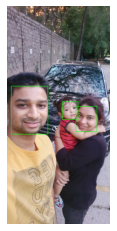

In [9]:
color = (0, 255, 0)
for box in boxes:
    (startX, startY, endX, endY) = box
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# cv2.imshow("Frame", image)
# cv2.waitKey(0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
from torchvision import transforms
import numpy as np
import PIL
def preprocess_image(img):

    image_transforms = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
    
    return image_transforms(img)

In [11]:
def detect_face_mask(image,plot_images=False):
    class_names = ['with_mask','without_mask']
    labelColor = [ (10, 255, 0), (255,0,0) ]
    font = cv2.FONT_HERSHEY_SIMPLEX
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mtcnn = MTCNN(keep_all=True, device=device)
    
    faces, _ = mtcnn.detect(image)

    MODEL_SAVE_PATH  = os.path.join('..','saved_models','facemaskdetection_new_mask_types.pth')

    model = torch.load(MODEL_SAVE_PATH,map_location=torch.device('cpu'))


    for face in faces:
        (startX, startY, endX, endY) = face.astype("int")

        # clamp coordinates that are outside of the image
        startX, startY = max(startX, 0), max(startY, 0)

        face_image = image[startY:endY, startX:endX]
        face_image = PIL.Image.fromarray( face_image )
        face_image = preprocess_image(face_image)
        face_image = face_image.unsqueeze_(0)
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(face_image)
            _, predicted = torch.max(output.data, 1)
        # draw face frame

        label = "Mask" if predicted==0 else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (255,0,0)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

        cv2.putText(image,
                    class_names[predicted],
                    (startX, startY-10),
                    font, 2, labelColor[predicted], 4)
        
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if plot_images:
        plt.figure(figsize = (12,8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        return image

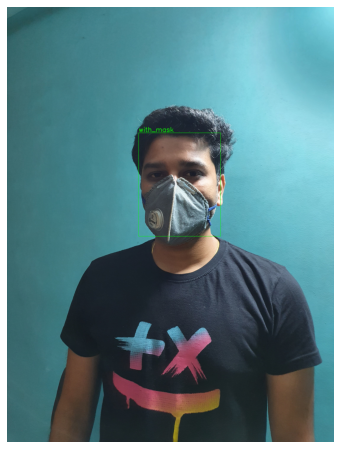

In [12]:
image = cv2.imread('../one_face_with_mask.jpg')
detect_face_mask(image,plot_images=True)

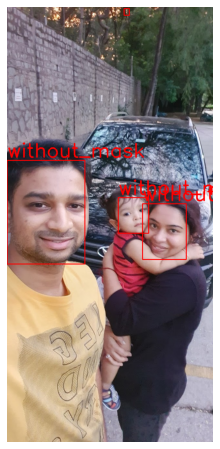

In [13]:
image = cv2.imread('../test_image_3_faces.jpg')
detect_face_mask(image,plot_images=True)

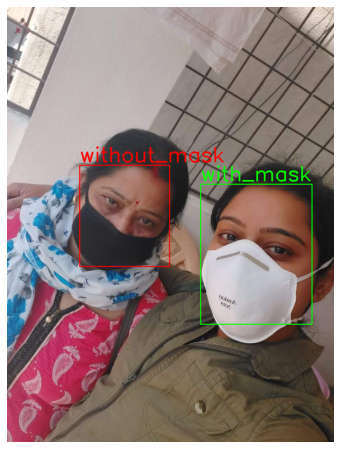

In [14]:
image = cv2.imread('../two_faces_with_mask-1.jpeg')
detect_face_mask(image,plot_images=True)

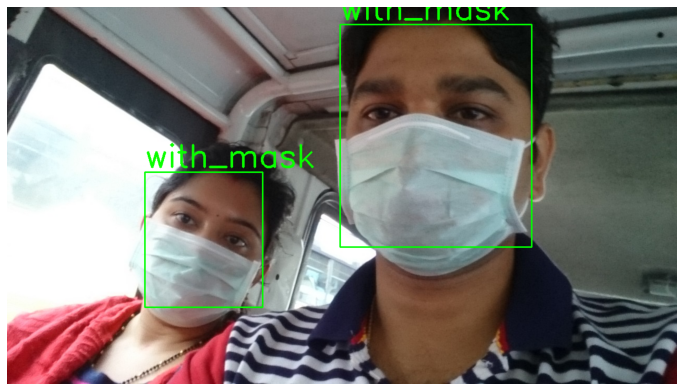

In [15]:
image = cv2.imread('../two_faces_with_mask-2.jpeg')
detect_face_mask(image,plot_images=True)

### Inferencing with Video

In [16]:
cap = cv2.VideoCapture(0)

In [17]:
while(True):
    ret, frame = cap.read()
    height,width = frame.shape[:2]
    frame = detect_face_mask(frame)
    # if(label == 'with_mask'):
    #     print("No Beep")
    # else:
    #     sound.play()
    #     print("Beep")   

    cv2.imshow('frame',cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()